# 2022 Systematic Trading Education Ceritificate


## Importing Modules

In [16]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

## The Parent Class and Evaluation function
In the code below we define the Strategies class which is a class containing all basic features that our individual backtesting strategy classes will inherit from.

This code has not been edited and is not part of the coursework.

In [17]:
####### THIS CODE IS THE SAME AS THE SKELETON CODE THAT WE COMPLETED IN THE FIRST LECTURE ########
####### PLEASE DON'T MESS WITH THIS CODE BLOCK AS IT WILL MAKE MARKING AN ABSOLUTE BALL-ACHE!!!!! #########
class Strategies():
  """
  A class that contains code that strategies later on will inherit from.
  params:
  -----
  codes = list of stock short codes
  -----
  """
  def __init__(self, codes):
    self.codes = codes
    self.strat = pd.DataFrame()
    self.data = pd.DataFrame()

  def import_data(self, start_date, end_date):
    """downloads all data for each backtest from yahoo Finance."""
    data = yf.download(self.codes, start_date, end_date)
    # if only one stock code is entered data is reformated so that
    # it is the same format as when multiple stocks are entered
    if len(self.codes) == 1:
      data.columns = [data.columns, self.codes*len(data.columns)]
    #returns data where any row containing NAN values is removed
    return data.dropna()

  def backtest(self, start_date, end_date):
    """
    Returns a list with elements of a time series' from yahoo finance as well as
    an array of values between -1 and 1 that represent the strategy over the giv
    en period with 1 representing a long postion in one stock, 0 representing a
    neutral postion and -1 representing a short position.
    params:
    -----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    -----
    """
    # sets up a dataframe to contain all strategy info for each stock at each 
    # time index
    self.data = self.import_data(start_date, end_date)
    self.strat = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                              columns = self.codes, index = self.data.index)
  
  def evaluate(self, start_date, end_date, fig_strat=True, fig_other=False,
               percentage_risk_free_rate = 0.1, **kwargs):
    """
    returns a dataframe with columns icluding the daily returns of the portfolio,
    the cumulative returns, the sharp ratio and all relevant plots of both the 
    stock price of each stock 
    and the strategy.
    params:
    ----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    fig = boolean variable that can be used to produce figures
    risk_free_rate = average rate of return on a very safe government issued bond
                     used to calculate the sharpe ratio with
    **kwargs are any specific keyword arguments that can be passed to the
    backtesting function to allow for comparison of the backtest for different
    possible parameters defined in the subclass.
    ----
    """
    # convert the monthly risk free rate to the daily rate for use
    # when calculating Sharpe and sortino ratios
    daily_rate = (1+ percentage_risk_free_rate/100)**(1/20) - 1
    # run the backtest function and define the stock price data to be once again
    # self.data and the signals self.strat
    strat = self.backtest(start_date, end_date, **kwargs)
    
    # sets up a new dataframe which will give the returns of the portfolio
    return_df = pd.DataFrame(columns= ["daily returns", "cumulative returns"],
                                  index = self.data.index)
    return_df["daily returns"][0] = 0
    
    # loops through the remaining dates and calculates the return across 
    # the portfolio
    for i in range(1, len(self.data)):
      return_df["daily returns"][i] = sum(100*self.strat[c][i-1]*(self.data["Adj Close"][c][i] - self.data["Adj Close"][c][i-1]) 
                                               /self.data["Adj Close"][c][i-1] for c in self.codes)
    # calculates the cumulative return for each date
    return_df["cumulative returns"] = ((return_df["daily returns"]/100+1).cumprod()-1)*100
    return_df.dropna()

    # calculates the sharpe ratio based on a low risk asset
    zero_count = 0
    while True:
      if sum(abs(self.strat[c].iloc[zero_count]) for c in self.codes):
        break
      zero_count += 1

    sharpe  = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df[zero_count:]) * daily_rate) /
                    return_df["daily returns"][zero_count:].std())


    sortino = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df) * daily_rate) /
                    return_df["daily returns"][(return_df["daily returns"] < 0)].std())
    
    
    #plots figures if fig TRUE
    if fig_strat:
      # plot of strategy returns
      plt.figure()
      plt.title("Strategy Backtest from "+ start_date+" to "+end_date)
      plt.plot(return_df["cumulative returns"])
      plt.show()

    if fig_other:
      # plot of all individual stocks
      for c in self.codes:
        plt.figure()
        plt.title("Buy and hold from "+ start_date+" to "+end_date+" for "+str(c))
        plt.plot(((self.data["Adj Close"][c].pct_change()+1).cumprod()-1)*100)
        plt.show()
    
    return [return_df, sharpe, sortino]

# Strategy Specific Classes
Each strategy will have to have at a minimum a specific backtesting method defined in the subclass. This method is where the trading algorithm will be implemented and will return a pandas dataframe with an index of all trading dates, columns for each stock in the backtest and data containing values between -1 and 1 representing the positon in each asset at each date.

## Buy and Hold Implementation
The first strategy example that we will brifly look at is simply buying and holding each selected asset with an equal weighting. This is acheived by first defining a pandas dataframe full of ones and then dividing through by the number of tickers (or codes). Although this isn't much of an algorithm, it is useful for seeing how the skeleton code works. 

This code has not been edited and is not part of the coursework

In [18]:
class StrategyBuyAndHold(Strategies):
    """
    This strategy buys and holds an equal amount of each security
    """
    def backtest(self, start_date, end_date):
      Strategies.backtest(self, start_date, end_date)
      # creates a normalized set of weightings representing a buy and hold
      # strategy with each column summing to one 
      self.strat = pd.DataFrame(data = (np.ones([len(self.data), 
                                len(self.codes)]) /len(self.codes)), 
                                columns = self.codes)
      
      return self.strat

[*********************100%***********************]  1 of 1 completed


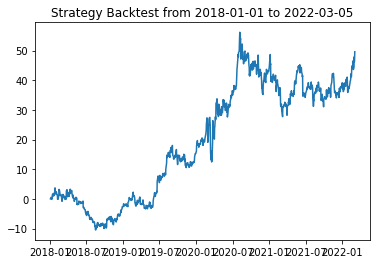

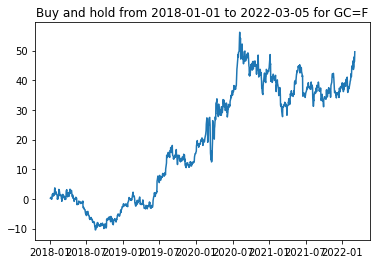

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03      0.190302           0.190302
 2018-01-04       0.24313           0.433895
 2018-01-05      0.068215           0.502405
 2018-01-08     -0.128764           0.372994
 ...                  ...                ...
 2022-02-28      0.683807          44.584007
 2022-03-01      2.263873          47.857205
 2022-03-02     -1.106878          46.220606
 2022-03-03      0.702796          47.248238
 2022-03-04      1.587053          49.585145
 
 [1051 rows x 2 columns],
 0.4154884089975461,
 0.5383114643026704]

In [19]:
# testing of the buy and hold strategy
testbh = StrategyBuyAndHold(["GC=F"])
testbh.evaluate("2018-01-01","2022-03-05", fig_other=True)

## Simple Moving Average Strategy
The concept behind this model involves comparing the short term moving average (e.g average over the last 5 days) with a long term moving average (e.g average over the last 200 days) at each time point. This comparison is what produces buy/sell signals.

At each time instance it is necessary to calculate the simple moving average of the previous **s** and **l** asset prices. Then if the short moving average crosses the long moving average i.e the value of the **small time period MA is greater than the large time period MA** then this is a **buy** signal. Otherwise enter a neutral position. (for this strategy there will be **no short selling**)

In [20]:
class StrategySMA(Strategies):
  """
  An implementation of Simple Moving Average Crossover Strategy
  """

  def backtest(self, start_date, end_date, s=5, l=200):
    """
    params:
    -----
    s = length of the shorter time period
    l = length of the longer time period
    -----
    """
    Strategies.backtest(self, start_date, end_date)
    long_ma = self.data["Close"].rolling(l).mean()
    short_ma = self.data["Close"].rolling(s).mean()
    data = np.select([short_ma.gt(long_ma), 
                     long_ma.ge(short_ma)], [1, 0])
    self.strat = pd.DataFrame(data, columns=short_ma.columns)
        
    return self.strat

[*********************100%***********************]  3 of 3 completed


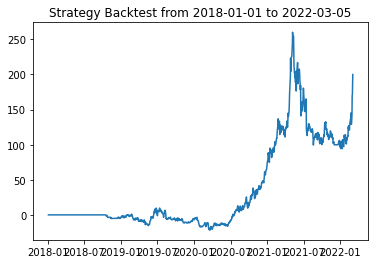

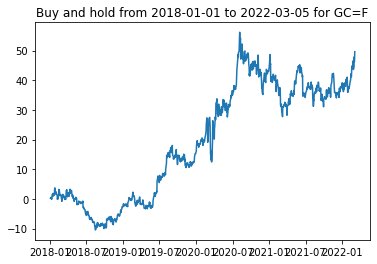

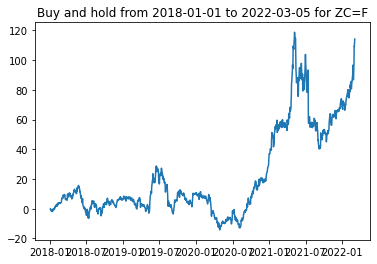

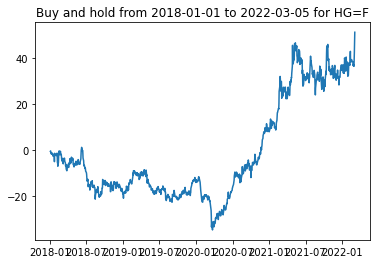

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28      5.830807          142.25387
 2022-03-01     11.516185         170.152274
 2022-03-02      0.296146          170.95232
 2022-03-03      4.852121         184.099255
 2022-03-04      5.586732          199.97112
 
 [1048 rows x 2 columns],
 0.5617382894615036,
 0.7329259491903887]

In [21]:
# Testing of the Simple Moving Average Crossover Strategy
testsma = StrategySMA(["GC=F", "ZC=F", "HG=F"])
testsma.evaluate("2018-01-01","2022-03-05", fig_other=True)

## Extension ~ KAMA Crossover + Inverse Volatility Weighting

An implementation of the Moving Average Crossover Strategy using Kaufman's Adaptive Moving Average indicator and Inverse Volatility portfolio weighting strategy.

The Momentum Strategy using Kaufman's Adaptive Moving Average is ideal as it filters out "market noise" during high volatility periods and prevents generating false signals.
A smoother, longer-term KAMA indicator can be used to represent the bigger trend of the performance of a stock and a shorter-term KAMA indicator can be used to generate the trading signals. The crossover of a faster KAMA line above a slower KAMA line indicates a change from downtrend to uptrend, which  triggers a buy signal, which is reversed once the faster KAMA line crosses back over.

The portfolio is weighted using the Inverse Volatility weighting strategy, which relies on using a stock's n day standard deviation to model price volatility and attempt to quantitatively measure the stock's risk. The lower the standard deviation, the higher weighting the stock will have.

In [22]:
class StrategyKAMA(Strategies):
  """
  An implementation of the Moving Average Crossover Strategy using KAMA 
  and Inverse Volatility portfolio weighting strategy
  """

  def backtest(self, start_date, end_date, n=10, f1=2, f2=5, s=30, 
               weighting=True, p=10):
    """
    params:
    -----
    n = number of time periods for the ER
    f1, f2 = length of the faster EMA time period constants
    s = length of the slower EMA time period constant
    weighting = boolean value, if True implements Inverse Volatility 
                weighting, if False implements Equal Weighting 
    p = number of the rolling window for standard deviation
    -----
    """
    Strategies.backtest(self, start_date, end_date)
    
    def KAMA(self, n, f, s):
      """
      Calculates Kaufman's Adaptive Moving Average
      """
      # Efficiency Ratio
      price = self.data["Adj Close"]
      change = abs(price-price.shift(n))
      volatility = abs(price-price.shift(1)).rolling(10).sum()
      er = change/volatility

      # Smoothing Constant
      faster = 2/(f+1)
      slower = 2/(s+1)
      sc = (er*(faster-slower)+slower)**2
      
      # Recursive KAMA
      kama = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                          columns = self.codes, index = self.data.index)
      first_value = True
      N = len(kama)
      for i in range(n,N):
        if first_value:
            kama.iloc[i] = price.iloc[i]
            first_value = False
        else:
            kama.iloc[i] = kama.iloc[i-1]+sc.iloc[i] \
                           *(price.iloc[i]-kama.iloc[i-1])
      
      return kama

    # Longer-term and shorter-term KAMA indicators
    short_ma = KAMA(self,n,f1,s)
    long_ma = KAMA(self,n,f2,s)

    # Define the trading signals
    # 1 is a buy signal and 0 is a neutral position
    data = np.where(short_ma.gt(long_ma),1,0)
    self.strat = pd.DataFrame(data, columns=short_ma.columns)

    # Implement Inverse Volatility Weighting scheme
    if weighting:
      rec_stdev = 1/self.data["Adj Close"].rolling(p).std().fillna(1)
      data = np.where(self.strat==1,rec_stdev,0)
      self.strat = pd.DataFrame(data, columns=short_ma.columns)

    # Normalise positions across each row
    N = len(self.strat)
    for i in range(N):
      row_sum = sum((abs(self.strat[c][i]) for c in self.codes))
      if row_sum:
        self.strat.iloc[i] /= row_sum

    return self.strat

If the value of **p** is greater than the value of **n**, some stocks will be equally weighted due to **.fillna(1)** function which is used in case the rolling window for the standard deviation is greater than the rolling window which calculates the moving average.

[*********************100%***********************]  3 of 3 completed


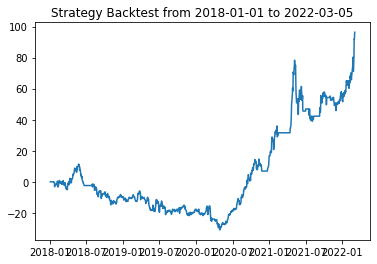

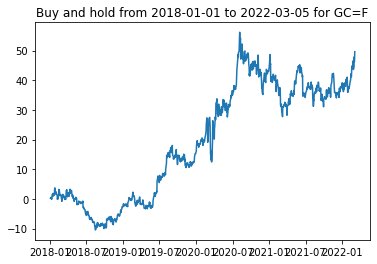

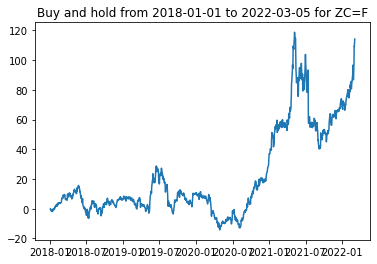

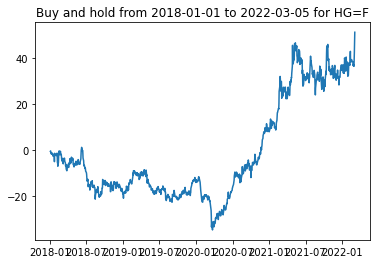

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28      5.746918          81.022641
 2022-03-01      6.046919          91.968934
 2022-03-02     -0.100872          91.775291
 2022-03-03      1.656198          94.951469
 2022-03-04      0.711032          96.337635
 
 [1048 rows x 2 columns],
 0.5368502646256353,
 0.6977593085821883]

In [23]:
# testing of the KAMA crossover strategy
testsma = StrategyKAMA(["GC=F", "ZC=F", "HG=F"])
testsma.evaluate("2018-01-01", "2022-03-05", fig_other=True)